# Проект: Churn Prediction для подписочного сервиса

## Бизнес-контекст

Компания предоставляет подписочный сервис для клиентов. Часть клиентов прекращает пользоваться услугами (churn), что приводит к потерям выручки и снижению lifetime value (LTV). Привлечение новых пользователей обычно дороже, чем удержание существующих, поэтому задача снижения оттока является критически важной.

## Бизнес-проблема

Необходимо заранее выявлять пользователей с высокой вероятностью churn, чтобы применять к ним удерживающие меры (коммуникации, скидки, персональные предложения). Это позволит снизить общий отток, повысить доход и сократить издержки на маркетинг.

## Цель работы

Построить модель, прогнозирующую вероятность churn на горизонте ближайшего периода, на основе исторических данных о пользователях и их поведении.

## Формулировка задачи 

Task: binary classification
Input: признаки клиента (демография, используемые услуги, показатели активности)
Output: вероятность churn ∈ [0, 1]
Target: Churn (Yes/No), далее будет преобразован в {1, 0}

## Особенности данных
 • табличные данные
 • смешанные типы признаков (категориальные и числовые)
 • несбалансированная выборка: ~26% churn, ~74% non-churn
 • положительный класс: churn = 1

## Ожидаемый ML-результат

Для каждого пользователя модель должна выдавать вероятность churn, позволяющую ранжировать пользователей по риску и выбирать сегмент для удержания.

## Метрики качества

Основные:
 • ROC-AUC
 • PR-AUC

Дополнительные:
 • F1-score
 • confusion matrix
 • Recall@k (для бизнес-сегмента high-risk)

## Бизнес-метрика успеха

Рост эффективности удерживающих кампаний через точечное воздействие на high-risk сегменты и, как следствие, снижение суммарного оттока и рост LTV.

In [9]:
import pandas as pd 
import numpy as np 
import sklearn
import catboost

## Проведем EDA анализ

### 1. Базовый обзор данных 

In [4]:
df = pd.read_csv("../data/telco_churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [18]:
df.shape

(7043, 21)

In [19]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### 2. Приведение типов + пропуски

In [20]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### 3. Разделение признаков

In [21]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

num_cols, cat_cols

(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['customerID',
  'gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'Churn'])

Уберем служебный и таргет столбцы

In [22]:
cat_cols.remove('customerID')
cat_cols.remove('Churn')

In [23]:
num_cols, cat_cols

(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

Теперь заполним пропуски в столбце TotalCharges нулями. Пользователи, у которых этот столбец пустой, вероятно зарегистрировались недавно и их tenure = 0. 

In [24]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

### 4. Одномерный анализ признаков

Числовые признаки

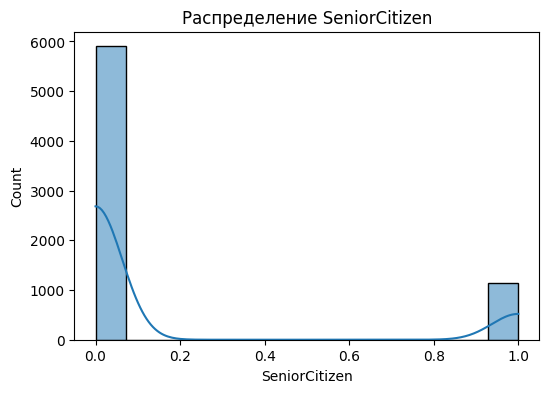

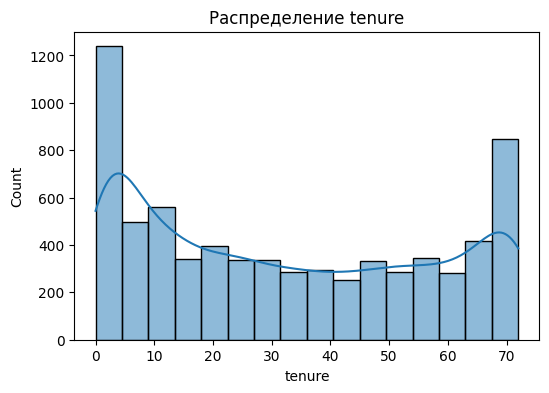

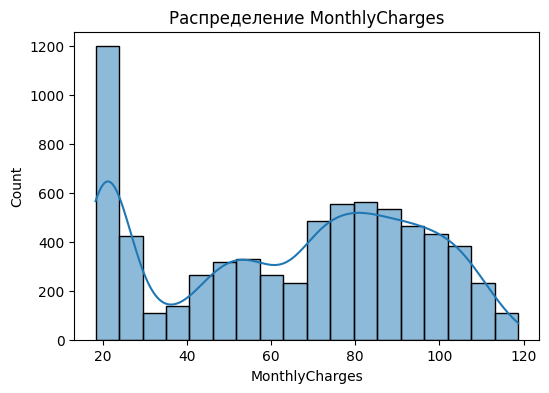

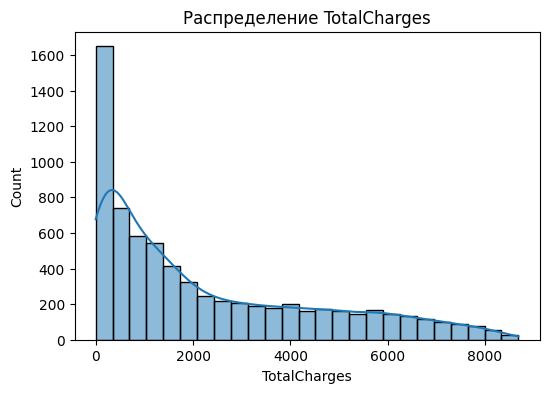

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Распределение {col}')
    plt.show()

Категориальные признаки

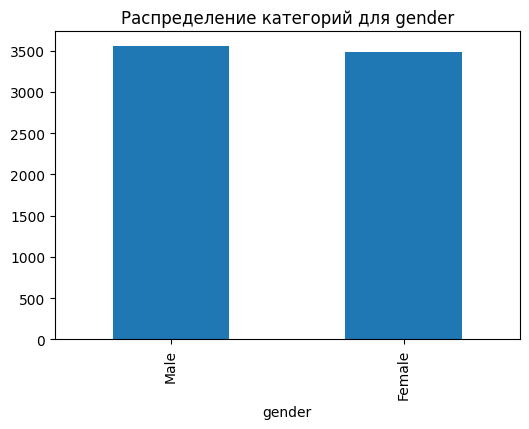

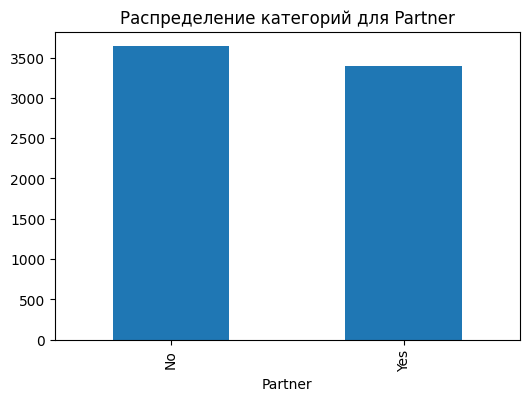

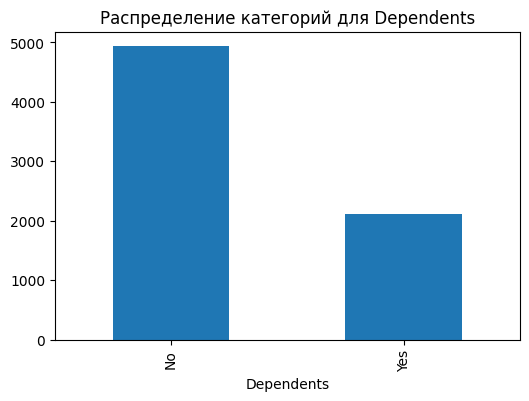

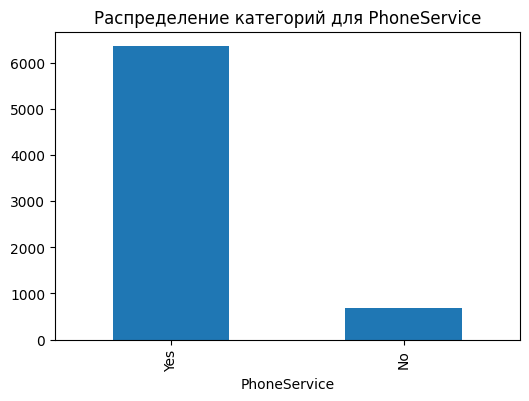

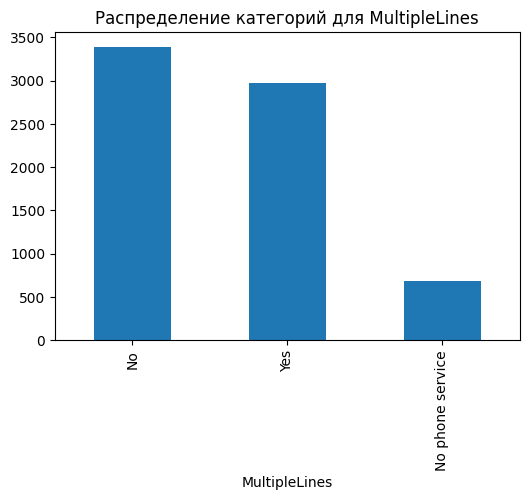

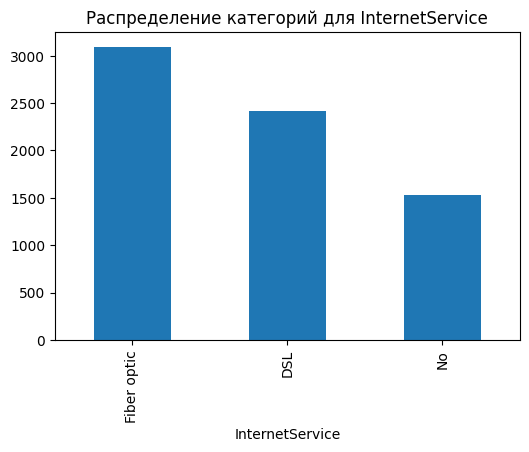

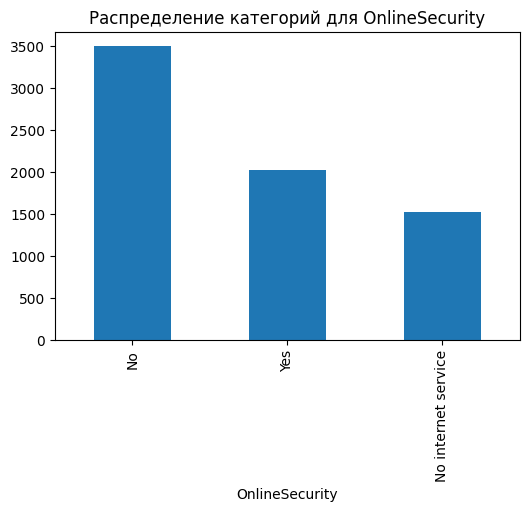

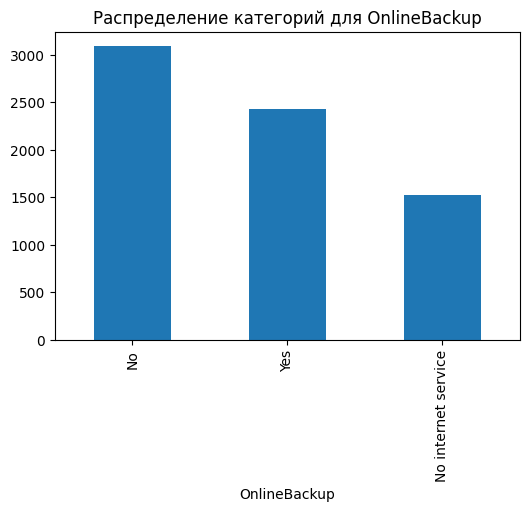

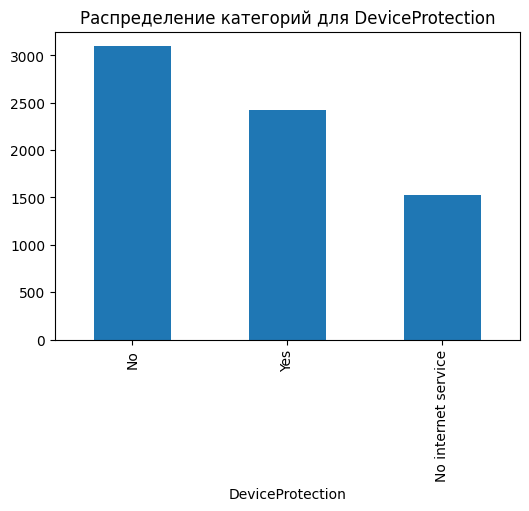

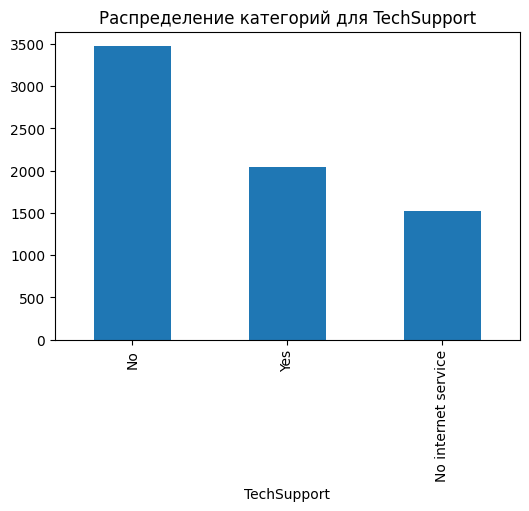

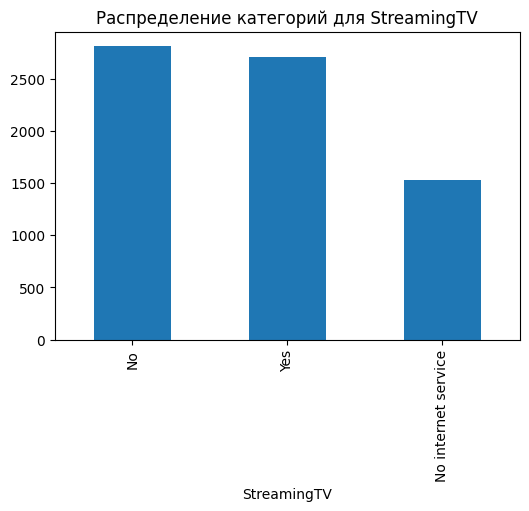

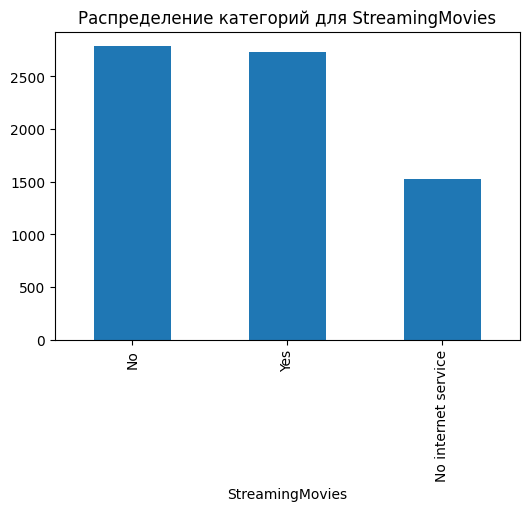

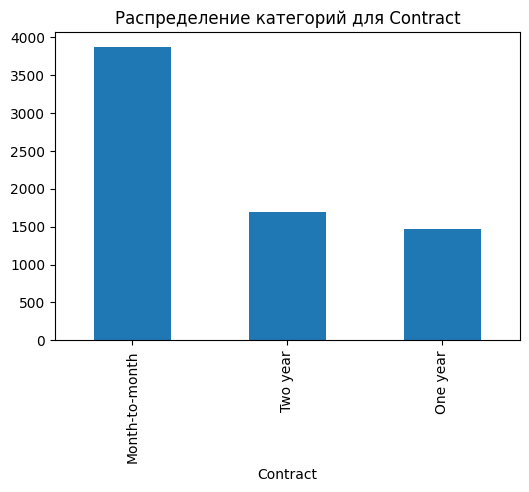

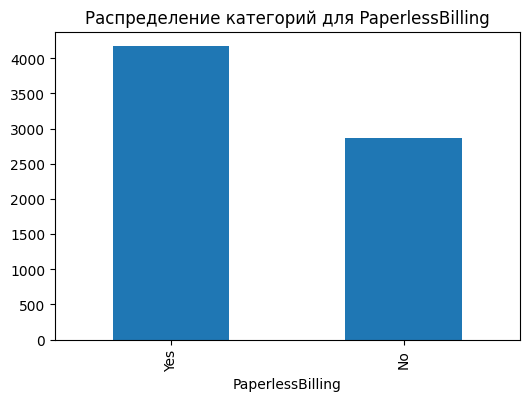

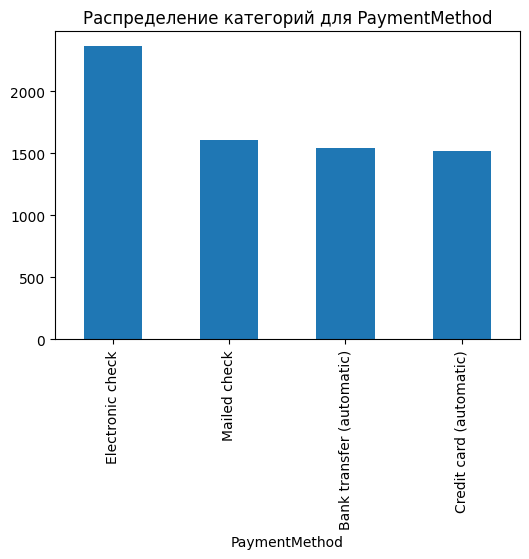

In [26]:
for col in cat_cols:
    plt.figure(figsize=(6,4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Распределение категорий для {col}')
    plt.show()

### 5. Связь признаков с Churn

Числовые признаки и Churn

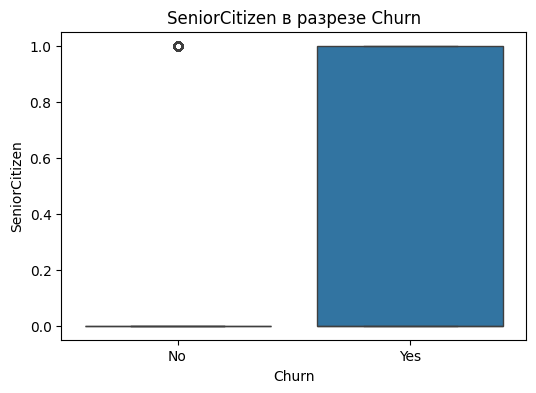

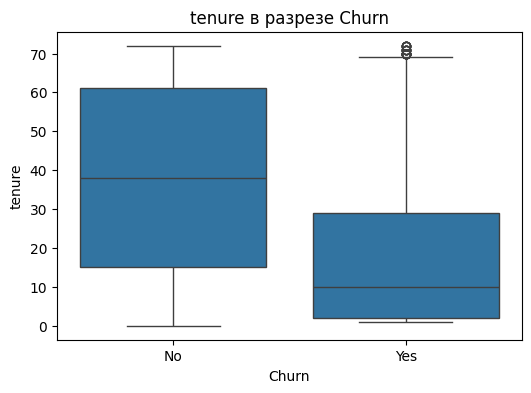

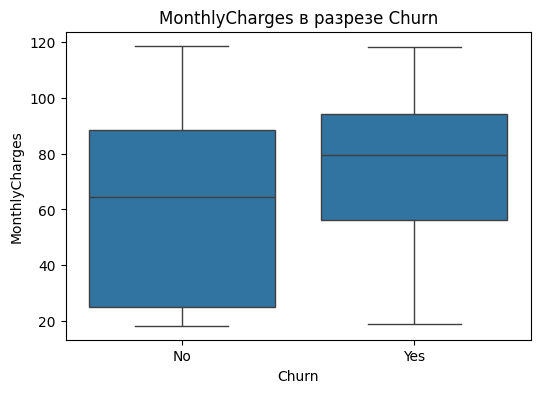

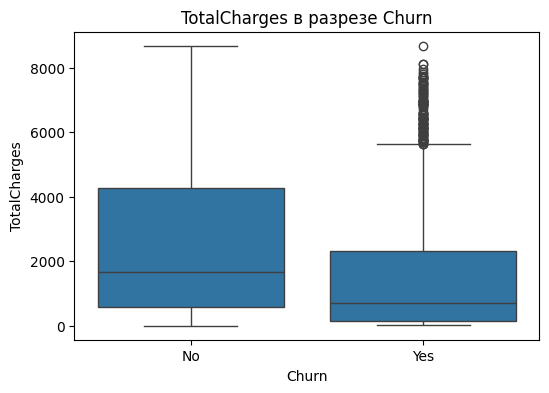

In [27]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} в разрезе Churn')
    plt.show()

In [28]:
df.groupby('Churn')[num_cols].mean()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
Churn,,,,
No,0.128721,37.569965,61.265124,2549.911442
Yes,0.254682,17.979133,74.441332,1531.796094


Категориальные признаки и Churn

In [30]:
df['ChurnFlag'] = (df['Churn'] == 'Yes').astype(int)

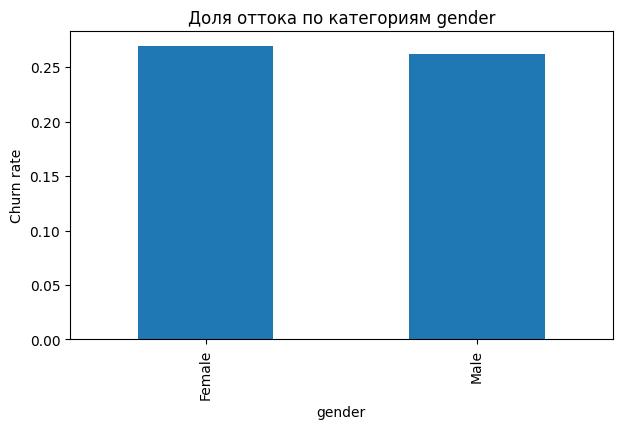

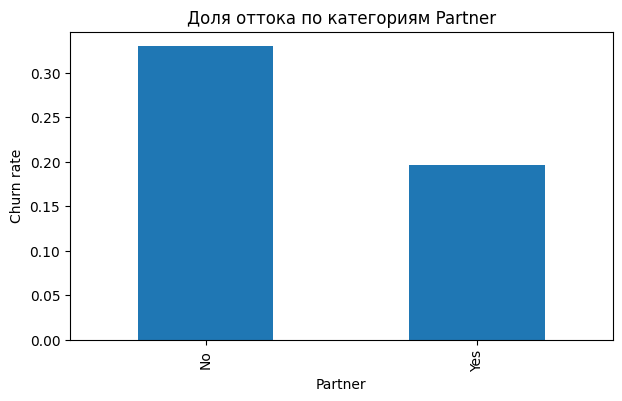

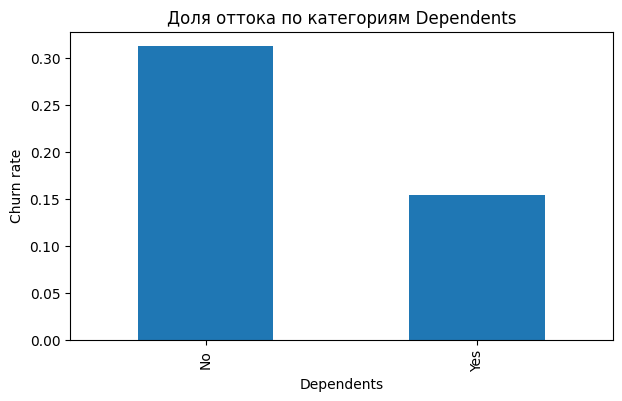

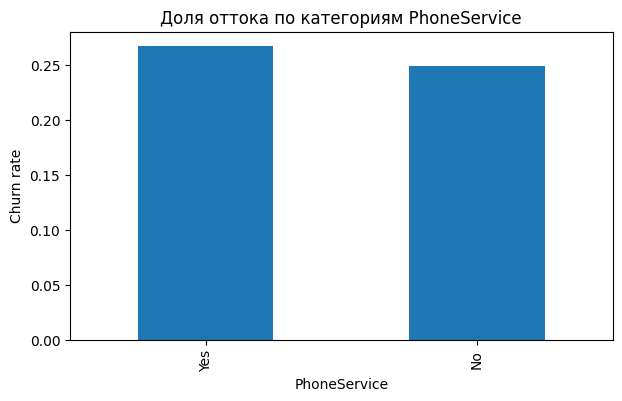

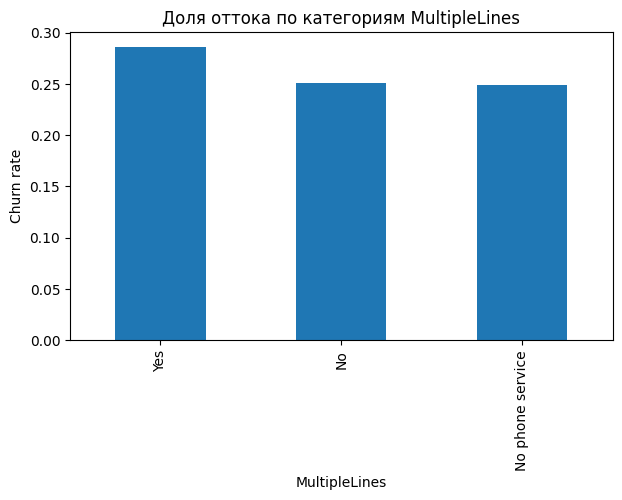

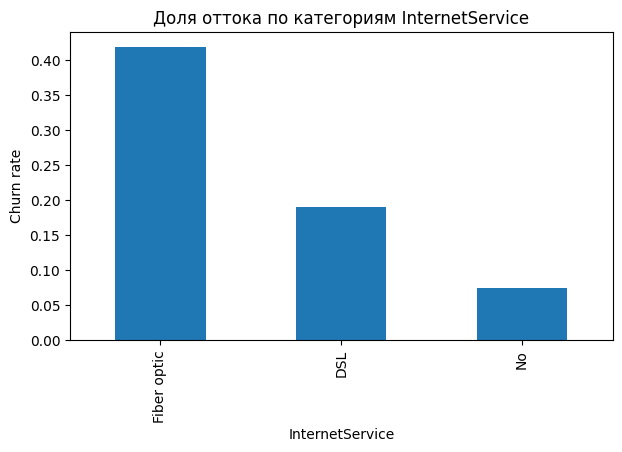

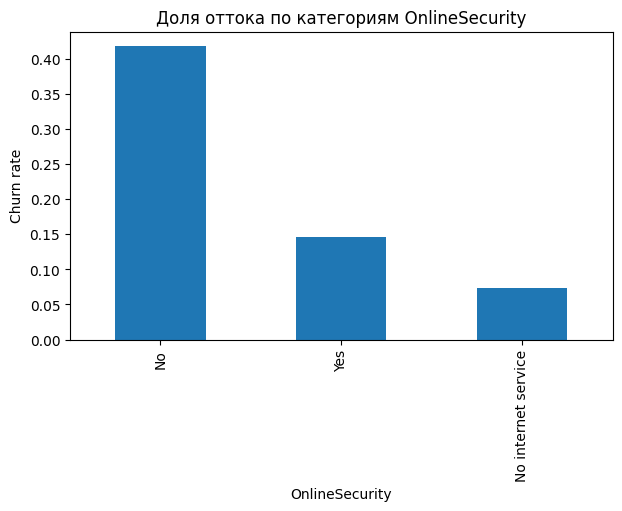

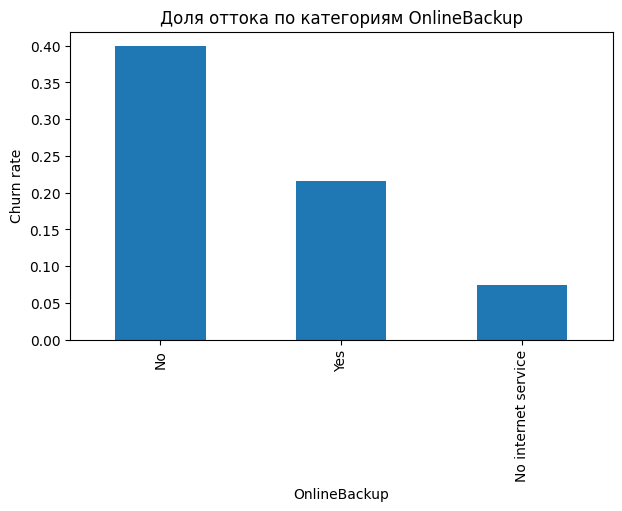

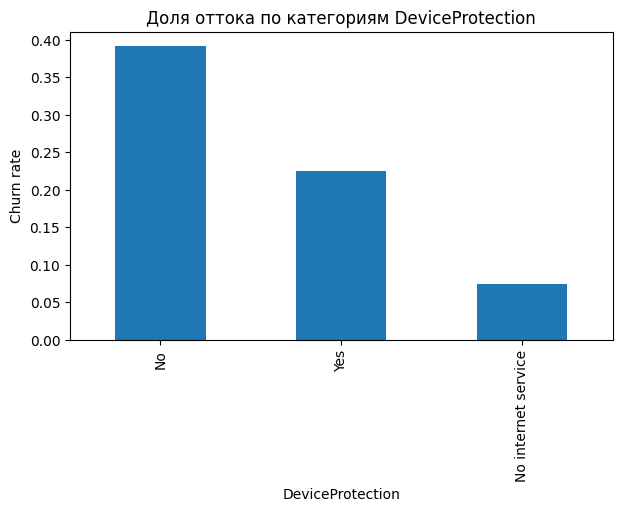

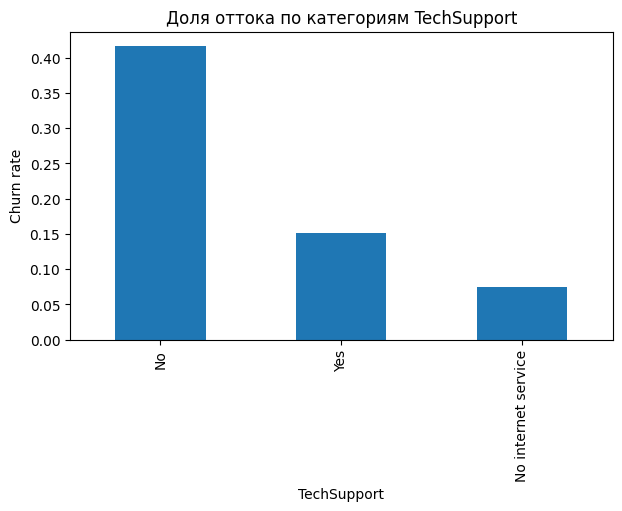

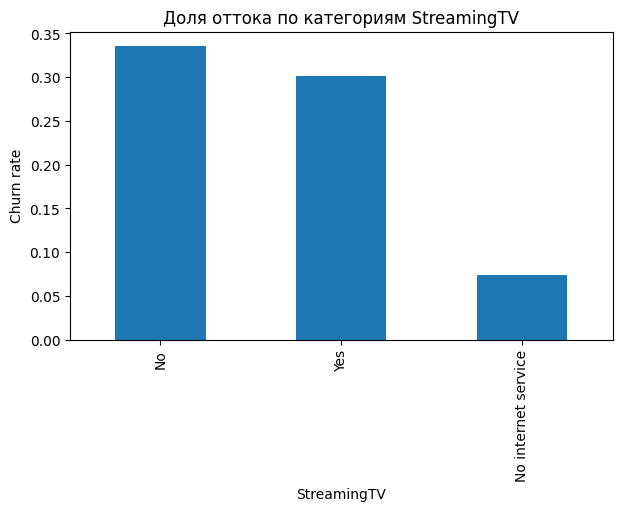

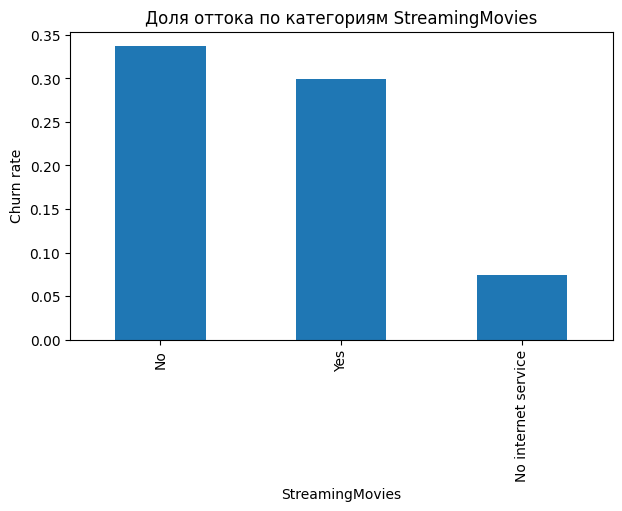

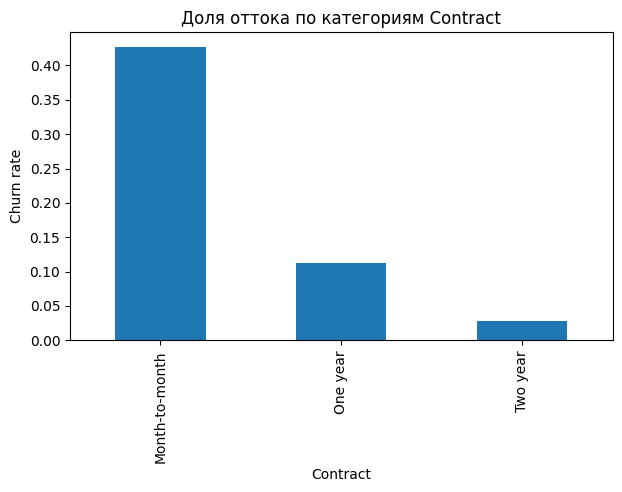

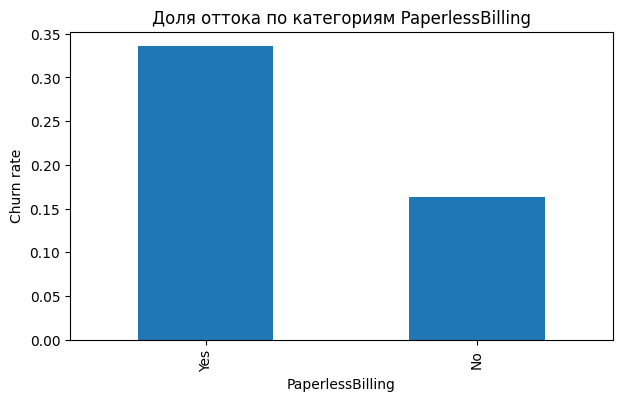

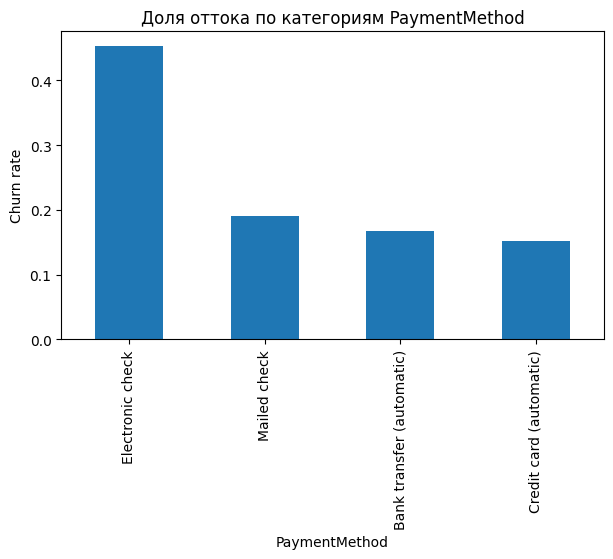

In [31]:
for col in cat_cols:
    churn_rate = (
        df.groupby(col)['ChurnFlag']
        .mean()
        .sort_values(ascending=False)
    )
    
    plt.figure(figsize=(7,4))
    churn_rate.plot(kind='bar')
    plt.title(f'Доля оттока по категориям {col}')
    plt.ylabel('Churn rate')
    plt.show()

**Вывод** 

Наиболее сильные факторы оттока: маленький tenure, высокая ежемесячная стоимость, отсутствие дополнительных сервисов (OnlineSecurity/TechSupport), модель контракта month-to-month, тип оплаты Electronic check, и пожилой возраст клиента.

### 6. Подготовка данных к модели

Целевая переменная

In [32]:
df['ChurnFlag'] = (df['Churn'] == 'Yes').astype(int)

Удаляем признаки, которые не нужны для модели или уже перенесены в бинарный флаг

In [33]:
X = df.drop(['customerID', 'Churn', 'ChurnFlag'], axis=1)
y = df['ChurnFlag']

Выполняем кодирование категорий. Для baseline-модели будем использовать One-Hot Encoding

In [34]:
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

- drop_first=True — убирает один уровень, чтобы избежать мультиколлинеарности (особенность логистики)

- модель сможет использовать категориальные признаки

Делаем train-test split, чтобы не переобучить модель

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

- test_size=0.2 обеспечивает 80% на обучение, 20% на тест

- stratify=y обеспечивает одинаковую долю churn/no-churn в train и test

In [36]:
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((5634, 30),
 (1409, 30),
 np.float64(0.2653532126375577),
 np.float64(0.2654364797728886))

### 7. Baseline модель

Обучение логистической регрессии

In [38]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=5000,
    solver='lbfgs'
)

logreg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


Предсказание

In [39]:
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

Оценка качества модели

In [40]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("F1:", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8069552874378992
ROC-AUC: 0.8423854917461056
F1: 0.6057971014492753
[[928 107]
 [165 209]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



Смотрим важность признаков

In [41]:
import pandas as pd
coef = pd.DataFrame({
    'feature': X_train.columns,
    'coef': logreg.coef_[0]
}).sort_values(by='coef', ascending=False)

coef.head(15)

,feature,coef
10,InternetService_Fiber optic,1.307764
23,StreamingMovies_Yes,0.425036
21,StreamingTV_Yes,0.424009
9,MultipleLines_Yes,0.388420
28,PaymentMethod_Electronic check,0.382162
26,PaperlessBilling_Yes,0.374627
8,MultipleLines_No phone service,0.274997
0,SeniorCitizen,0.147624
7,PhoneService_Yes,0.123775
29,PaymentMethod_Mailed check,0.065142


In [42]:
coef.tail(15)

,feature,coef
27,PaymentMethod_Credit card (automatic),-0.037404
1,tenure,-0.053085
15,OnlineBackup_Yes,-0.074250
14,OnlineBackup_No internet service,-0.191610
20,StreamingTV_No internet service,-0.191610
11,InternetService_No,-0.191610
12,OnlineSecurity_No internet service,-0.191610
22,StreamingMovies_No internet service,-0.191610
16,DeviceProtection_No internet service,-0.191610
18,TechSupport_No internet service,-0.191610


**Вывод**:

Baseline моделью была выбрана Logistic Regression. Модель демонстрирует метрики: Accuracy = 0.81, ROC-AUC = 0.84, F1 = 0.61. Анализ коэффициентов показал, что наибольший вклад в риск оттока вносят: короткий срок контракта (month-to-month), тип интернет-сервиса Fiber optic, бумажное выставление счетов, отсутствие дополнительных сервисов (OnlineSecurity, TechSupport), а также метод оплаты Electronic check. Признаки Contract_One year, Contract_Two year, OnlineSecurity_Yes, TechSupport_Yes существенно снижают риск churn, что согласуется с бизнес-логикой и с EDA. Baseline моделирует churn лучше простого бенчмарка и используется как точка отсчёта для дальнейшего улучшения модели.

### 8. CatBoost

Подготовим данные

In [43]:
from sklearn.model_selection import train_test_split

X_cb = df.drop(['customerID', 'Churn', 'ChurnFlag'], axis=1)
y_cb = df['ChurnFlag']

X_cb_train, X_cb_test, y_cb_train, y_cb_test = train_test_split(
    X_cb, y_cb,
    test_size=0.2,
    random_state=42,
    stratify=y_cb
)

X_cb_train.shape, X_cb_test.shape

((5634, 19), (1409, 19))

Оборачиваем в Pool

In [45]:
from catboost import Pool

train_pool = Pool(
    data=X_cb_train,
    label=y_cb_train,
    cat_features=cat_cols  # можно передавать имена столбцов
)

test_pool = Pool(
    data=X_cb_test,
    label=y_cb_test,
    cat_features=cat_cols
)

Обучаем CatBoostClassifier

In [46]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

cat_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True
)

0:	test: 0.7944651	best: 0.7944651 (0)	total: 279ms	remaining: 4m 38s
100:	test: 0.8462141	best: 0.8464969 (67)	total: 8.81s	remaining: 1m 18s
200:	test: 0.8432225	best: 0.8464969 (67)	total: 16.1s	remaining: 1m 4s
300:	test: 0.8403782	best: 0.8464969 (67)	total: 23.8s	remaining: 55.2s
400:	test: 0.8380932	best: 0.8464969 (67)	total: 30s	remaining: 44.8s
500:	test: 0.8366853	best: 0.8464969 (67)	total: 35.4s	remaining: 35.3s
600:	test: 0.8338655	best: 0.8464969 (67)	total: 40.9s	remaining: 27.2s
700:	test: 0.8350926	best: 0.8464969 (67)	total: 46.8s	remaining: 20s
800:	test: 0.8333346	best: 0.8464969 (67)	total: 52.7s	remaining: 13.1s
900:	test: 0.8321359	best: 0.8464969 (67)	total: 59.6s	remaining: 6.55s
999:	test: 0.8312783	best: 0.8464969 (67)	total: 1m 6s	remaining: 0us

bestTest = 0.8464969387
bestIteration = 67

Shrink model to first 68 iterations.


Предсказания и метрики

In [47]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report

# вероятности класса 1 (churn)
y_cb_proba = cat_model.predict_proba(test_pool)[:, 1]

# жёсткий прогноз при пороге 0.5
y_cb_pred = (y_cb_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_cb_test, y_cb_pred))
print("ROC-AUC:", roc_auc_score(y_cb_test, y_cb_proba))
print("F1:", f1_score(y_cb_test, y_cb_pred))
print(confusion_matrix(y_cb_test, y_cb_pred))
print(classification_report(y_cb_test, y_cb_pred))

Accuracy: 0.8055358410220014
ROC-AUC: 0.8464969386964272
F1: 0.5994152046783626
[[930 105]
 [169 205]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.55      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



Важность признаков

In [48]:
import pandas as pd

feature_importance = cat_model.get_feature_importance(train_pool)
fi = pd.DataFrame({
    'feature': X_cb_train.columns,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

fi.head(15)

,feature,importance
14,Contract,19.361776
7,InternetService,16.964240
4,tenure,16.514940
18,TotalCharges,8.655937
17,MonthlyCharges,6.349195
16,PaymentMethod,5.256430
8,OnlineSecurity,5.164221
9,OnlineBackup,4.390831
15,PaperlessBilling,3.828106
11,TechSupport,3.009742


In [49]:
fi.tail(15)

,feature,importance
17,MonthlyCharges,6.349195
16,PaymentMethod,5.256430
8,OnlineSecurity,5.164221
9,OnlineBackup,4.390831
15,PaperlessBilling,3.828106
11,TechSupport,3.009742
6,MultipleLines,2.993791
1,SeniorCitizen,1.543924
13,StreamingMovies,1.505350
5,PhoneService,1.237642


Подбор порога для F1

по умолччанию был выбран порог 0.5, можно попробовать подобрать лучший порог.

In [50]:
best_thr = 0.5
best_f1 = 0

for thr in np.linspace(0.2, 0.8, 25):
    y_tmp = (y_cb_proba >= thr).astype(int)
    f1 = f1_score(y_cb_test, y_tmp)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

best_thr, best_f1

(np.float64(0.35000000000000003), 0.6386946386946387)

In [51]:
y_cb_pred_opt = (y_cb_proba >= best_thr).astype(int)

print("Best threshold:", best_thr)
print("F1 (opt):", f1_score(y_cb_test, y_cb_pred_opt))
print(confusion_matrix(y_cb_test, y_cb_pred_opt))

Best threshold: 0.35000000000000003
F1 (opt): 0.6386946386946387
[[825 210]
 [100 274]]


**Вывод**

После построения baseline-моделей (Logistic Regression) в качестве финальной модели был выбран CatBoostClassifier благодаря лучшему качеству и корректной работе с категориальными признаками.

*Метрики качества*

Без подбора порога (thr = 0.5):
- Accuracy: 0.806
- ROC-AUC: 0.846
- F1-score: 0.60
- Recall (churn): 0.55

После оптимизации порога (best_thr = 0.35):
- F1-score: 0.64
- Recall (churn): 0.73

Выбор оптимального порога позволил существенно снизить количество пропущенных churn-клиентов (FN), что важно для задач удержания.


*Ключевые признаки, влияющие на отток:*

1. Contract
2. InternetService
3. tenure
4. TotalCharges
5. MonthlyCharges
6. PaymentMethod
7. OnlineSecurity

Вопрос контракта и дополнительных сервисов оказывает наиболее существенное влияние на вероятность ухода.

*Итог*

Модель CatBoost с оптимизированным порогом показала улучшение F1 на 7% относительно baseline и позволила повысить recall churn-клиентов при приемлемом числе FP. Модель подходит для применения в потребительском телеком-продукте для сценариев проактивного удержания.


## Итоговый вывод по проекту

В рамках проекта была решена задача прогнозирования оттока клиентов телеком-сервиса на горизонте 1 месяца. Для этого были проведены этапы: предварительный анализ данных (EDA), построение baseline-модели и обучение финальной модели бустинга.

На этапе EDA:
- проанализировано распределение признаков и целевой переменной;
- выявлены ключевые поведенческие и тарифные факторы, связанные с повышенным риском churn: низкий tenure, месячные контракты, высокая стоимость ежемесячного платежа, отсутствие дополнительных сервисов (OnlineSecurity/TechSupport) и использование Electronic check;
- выделены сегменты клиентов с наибольшей вероятностью ухода (новички, пользователи Fiber optic, клиенты без семейного контекста).

На этапе моделирования:
- в качестве baseline использована Logistic Regression, показавшая ROC-AUC = 0.842 и F1 = 0.61;
- затем обучена модель CatBoost, улучшившая качество до ROC-AUC = 0.846 и F1 = 0.64 при оптимизации порога;
- оптимизация порога позволила увеличить recall churn-клиентов до 0.73 и сократить количество пропущенных churn-пользователей (FN), что критично для сценариев удержания.

Интерпретация результатов:
- feature importance в CatBoost подтвердил результаты EDA: контрактная политика, тип интернет-сервиса, срок использования и тарифные параметры являются наиболее важными факторами оттока;
- модель позволяет выделять клиентов с повышенным риском churn, что может быть использовано для таргетированных retention-кампаний и персонализированных офферов.

Итог:
построенная модель демонстрирует устойчивые результаты на тестовой выборке и может применяться в задачах улучшения удержания пользователей. Проект показал, что использование бустинга и корректный выбор метрик (recall/F1 для churn) позволяют существенно улучшить качество по сравнению с baseline. Также подтверждена ценность EDA для выявления причин churn и формирования продуктовых гипотез.